导入相关包

In [1]:
import copy
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from IPython import display
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
TRAIN_PATH = "../titanic/train.csv" 
TEST_PATH = "../titanic/test.csv"

In [3]:
ID = 'PassengerId'
TARGET = 'Survived'

In [4]:
# 读取训练集文件，并查看相关信息
train_data = pd.read_csv(TRAIN_PATH)
train_data.head(3) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
# 查看数据的基本信息：（行数、列数、列索引、列类型、列非空值个数、内存占用）
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# 其中PassengerId、Name、Ticket与是否生存无关，删除
train_data = train_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
train_data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S


In [7]:
train_data.info() # 其中Age只有714个数据，缺少了891-714个数据；Cabin仅有204个，Embarked缺少2个数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


Survived（存活基本情况）

In [8]:
# 891人当中，共有多少人生还
total_survived_num = train_data['Survived'].sum()
total_no_survived_num = 891 - total_survived_num
print(f"生还者总共{total_survived_num}人， 死亡者总共{total_no_survived_num}人")

生还者总共342人， 死亡者总共549人


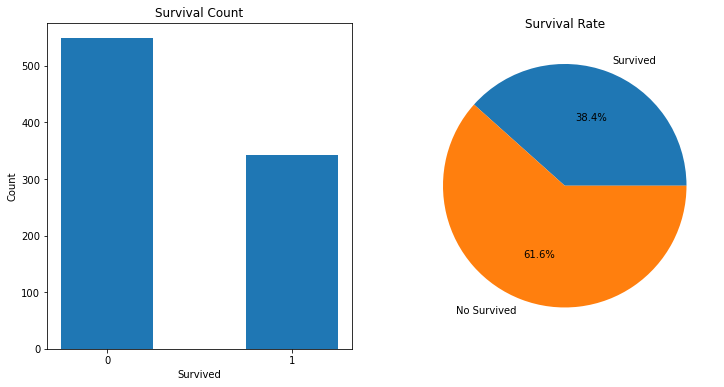

In [9]:
plt.figure(figsize=(12, 6)) 
# 绘制柱状图
plt.subplot(1, 2, 1)
plt.bar([1, 0], [total_survived_num, total_no_survived_num], width=0.5)
plt.xticks(ticks=[0, 1])
plt.title('Survival Count')
plt.xlabel('Survived')
plt.ylabel('Count')

# 绘制饼状图
plt.subplot(1, 2, 2)
plt.pie([total_survived_num, total_no_survived_num], 
        labels=['Survived', 'No Survived'], autopct="%.1f%%")
plt.title('Survival Rate')
plt.show()

In [10]:
# 定义绘图函数
def picture_bar(s, n, d, labels, title_1, title_2, figsize=(14, 5), width=0.3):
    x = np.arange(len(labels)) 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    rects1 = ax1.bar(x - width/2, s, width, label='Number of survivors')
    rects2 = ax1.bar(x + width/2, d, width, label='death toll')

    ax1.set_ylabel('Count')
    ax1.set_title(title_1)
    ax1.set_xticks(x, labels)
    ax1.legend()

    #  padding ：标签与柱子之间的距离，单位为像素。浮点数。默认值为0。
    ax1.bar_label(rects1, padding=2)
    ax1.bar_label(rects2, padding=2)

    r = [a/b*100 for a,b in zip(s,n)]
    rects = ax2.bar(x, r, width, color='g')
    ax2.set_ylabel('Rate')
    ax2.set_title(title_2)
    ax2.set_xticks(x, labels)
    ax2.bar_label(rects, fmt='%.1f%%', padding=2)
    # tight_layout会自动调整子图参数，使之填充整个图像区域。
    fig.tight_layout() 
    plt.show() # 可以省略

Pclass（客舱等级）

In [11]:
# Pclass（客舱等级），不同级别客舱的人数和比例
x = train_data[['Pclass', 'Survived']].groupby(['Pclass']).count()
x 

,Survived
Pclass,
1,216
2,184
3,491


In [12]:
# 不同级别客舱生还人数
x = train_data[train_data['Survived'] == 1]
x = x[['Pclass', 'Survived']].groupby('Pclass').count()
x

,Survived
Pclass,
1,136
2,87
3,119


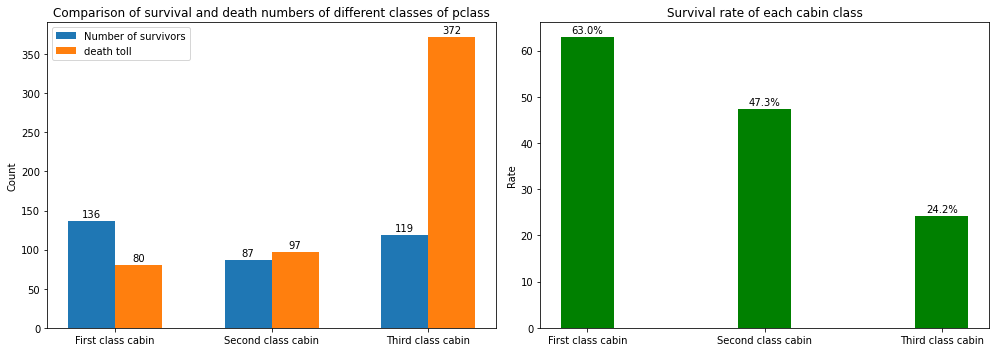

In [13]:
s = train_data[train_data['Survived'] == 1]
s = s[['Pclass', 'Survived']].groupby('Pclass').count()
s = s['Survived']
n = train_data[['Pclass', 'Survived']].groupby(['Pclass']).count()
n = n['Survived']
d = train_data[train_data['Survived'] == 0]
d = d[['Pclass', 'Survived']].groupby('Pclass').count()
d = d['Survived']
labels = ['First class cabin', 'Second class cabin', 'Third class cabin']
picture_bar(s, n, d, labels, title_1="Comparison of survival and death numbers of different classes of pclass", 
            title_2="Survival rate of each cabin class")

Sex（性别)

In [14]:
# 不同性别人数比例及生还率
x = train_data[['Sex','Survived']].groupby('Sex').count()
x

,Survived
Sex,
female,314
male,577


In [15]:
x = train_data[train_data['Survived'] == 1]
x = x[['Sex', 'Survived']].groupby('Sex').count()
x

,Survived
Sex,
female,233
male,109


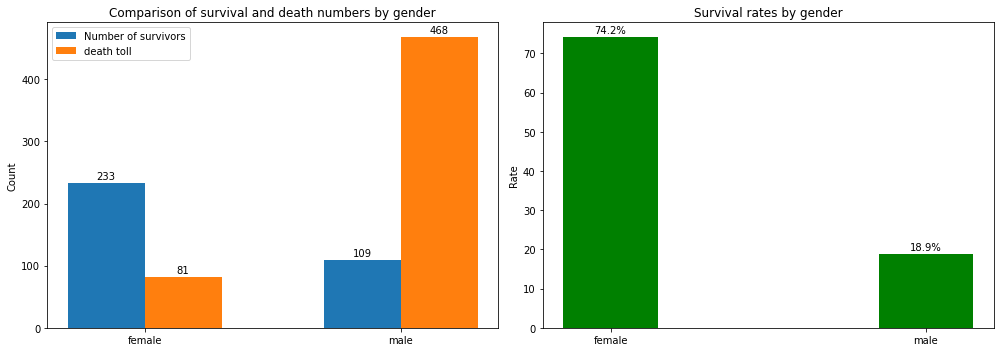

In [16]:
s = train_data[train_data['Survived'] == 1]
s = s[['Sex', 'Survived']].groupby('Sex').count()
s = s['Survived']
n = train_data[['Sex', 'Survived']].groupby(['Sex']).count()
n = n['Survived']
d = train_data[train_data['Survived'] == 0]
d = d[['Sex', 'Survived']].groupby('Sex').count()
d = d['Survived']
labels = ['female', 'male']
picture_bar(s, n, d, labels, title_1="Comparison of survival and death numbers by gender", 
            title_2="Survival rates by gender")

Age(年龄)

In [17]:
# 不同年龄比例及生还率
# 由于Age是有缺失值的，所以先处理缺失值问题。填充的年龄为年龄平均值。
# 查看缺少的年龄数
nan_age_count = train_data['Age'].isnull().sum()
print(f"缺少的年龄数:{nan_age_count}")
# 求年龄平均值
avg_age = train_data['Age'].mean()
print(f"年龄平均值:{avg_age}")
# 填充缺失的年龄
train_data['Age'] = train_data['Age'].fillna(avg_age)

缺少的年龄数:177
年龄平均值:29.69911764705882


In [18]:
train_data['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

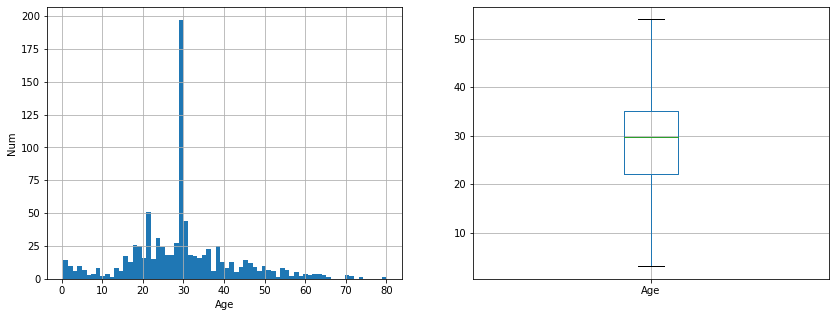

In [19]:
# 查看年龄分布
plt.figure(figsize=(14, 5))
# 绘制年龄分布图
plt.subplot(1, 2, 1)
train_data['Age'].hist(bins = 70) # bins,数据划分的份数
plt.xlabel('Age')
plt.ylabel('Num')
# 绘制年龄分布图
plt.subplot(1, 2, 2)
train_data.boxplot(column='Age', showfliers=False)# 表示是否显示异常值，默认显示
plt.show() 

In [20]:
# 按照年龄，将乘客划分为儿童，少年，成年人，老年人，分析四个群体的生还情况
children_df = train_data[train_data['Age'] <= 12]
juvenile_df = train_data[(train_data['Age'] > 12) & (train_data['Age'] < 18)]
adults_df = train_data[(train_data['Age'] >= 18) & (train_data['Age'] < 65)]
agedness_df = train_data[train_data['Age'] >= 65]

In [21]:
# 儿童数量
children_count = children_df['Survived'].count()
# 少年数量
juvenile_count = juvenile_df['Survived'].count()
# 成年人数量
adults_count = adults_df['Survived'].count()
# 老年人数量
agedness_count = agedness_df['Survived'].count()
children_count, juvenile_count, adults_count, agedness_count

(69, 44, 767, 11)

In [22]:
# 儿童中存活的数量
children_survived_count = children_df['Survived'].sum()
# 少年中存活的数量
juvenile_survived_count = juvenile_df['Survived'].sum()
# 成年人中存活的数量
adults_survived_count = adults_df['Survived'].sum()
# 老年人中存活的数量
agedness_survived_count = agedness_df['Survived'].sum()
children_survived_count, juvenile_survived_count, adults_survived_count, agedness_survived_count

(40, 21, 280, 1)

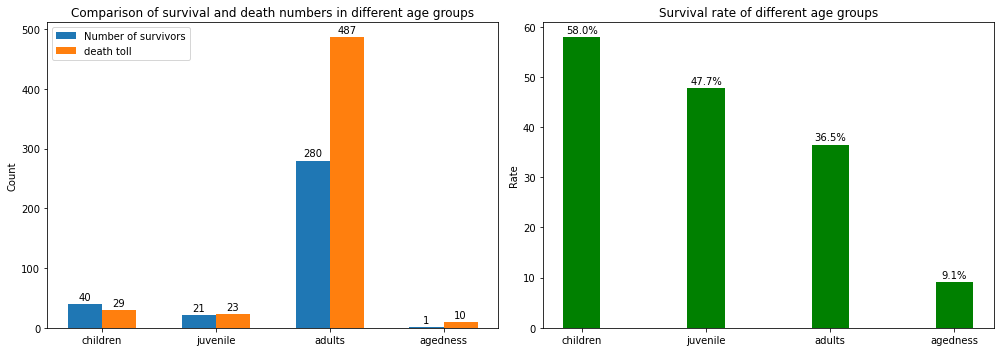

In [23]:
s = [children_survived_count, juvenile_survived_count, adults_survived_count, agedness_survived_count]
n = [children_count, juvenile_count, adults_count, agedness_count]
# 死亡人数列表
d = [b - a for a,b in zip(s, n)]
labels = ['children', 'juvenile', 'adults', 'agedness']
picture_bar(s, n, d, labels, title_1="Comparison of survival and death numbers in different age groups", 
            title_2="Survival rate of different age groups")

SibSp（兄弟姐妹）

In [24]:
# 有兄弟姐妹的乘客生还人数和生还率
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]
# 有兄弟姐妹的乘客数
sibsp_count = sibsp_df['Survived'].count()
# 没有兄弟姐妹的乘客数
no_sibsp_count = no_sibsp_df['Survived'].count()
sibsp_count, no_sibsp_count

(283, 608)

In [25]:
# 有兄弟姐妹的乘客生还数
sibsp_survived_count = sibsp_df['Survived'].sum()
# 没有兄弟姐妹的乘客生还数
no_sibsp_survived_count = no_sibsp_df['Survived'].sum()
sibsp_survived_count, no_sibsp_survived_count

(132, 210)

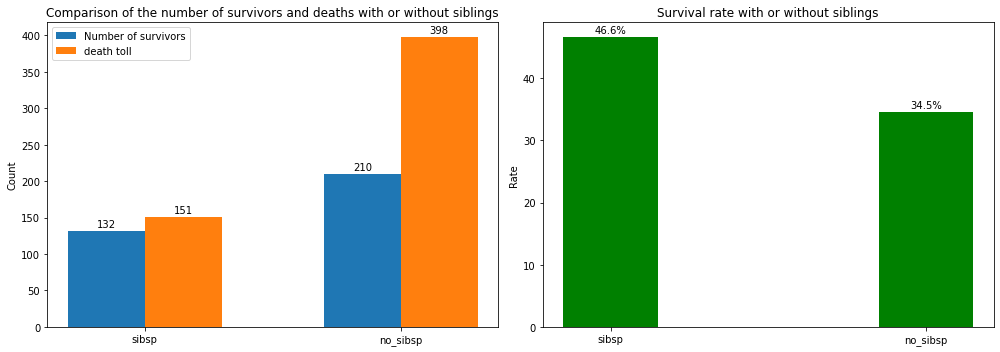

In [26]:
labels = ['sibsp', 'no_sibsp']
s = [sibsp_survived_count, no_sibsp_survived_count]
n = [sibsp_count, no_sibsp_count]
d = [b - a for a,b in zip(s,n)]
picture_bar(s, n, d, labels, title_1="Comparison of the number of survivors and deaths with or without siblings", 
            title_2="Survival rate with or without siblings")

Parch（父母子女）

In [27]:
# 有父母子女的乘客生还人数和生还率
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]
# 有父母子女的乘客数
parch_count = parch_df['Survived'].count()
# 没有父母子女的乘客数
no_parch_count = no_parch_df['Survived'].count()
parch_count, no_parch_count

(213, 678)

In [28]:
# 有父母子女的乘客生还数
parch_survived_count = parch_df['Survived'].sum()
# 没有父母子女的乘客生还数
no_parch_survived_count = no_parch_df['Survived'].sum()
parch_survived_count, no_parch_survived_count

(109, 233)

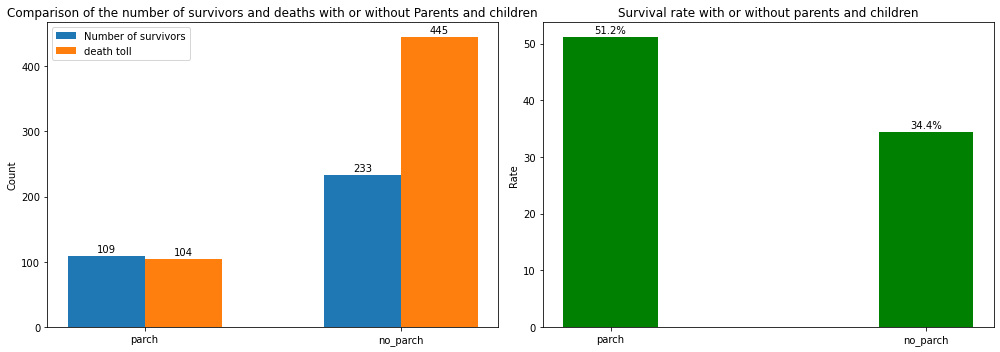

In [29]:
labels = ['parch', 'no_parch']
s = [parch_survived_count, no_parch_survived_count]
n = [parch_count, no_parch_count]
d = [b - a for a,b in zip(s,n)]
picture_bar(s, n, d, labels, title_1="Comparison of the number of survivors and deaths with or without Parents and children", 
            title_2="Survival rate with or without parents and children")

Fare（票价）

In [30]:
# 票价分布
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

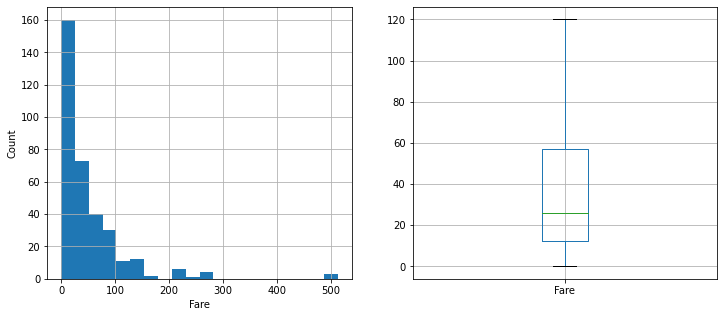

In [31]:
# 绘制存活乘客的票价分布图
plt.figure(figsize=(12, 5))
# 绘制存活乘客的票价分布图
plt.subplot(1, 2, 1)
train_data[train_data['Survived'] == 1]['Fare'].hist(bins = 20)
plt.xlabel('Fare')
plt.ylabel('Count')
# 绘制存活乘客的票价盒图
plt.subplot(1, 2, 2)
train_data[train_data['Survived'] == 1].boxplot(column='Fare', showfliers=False)
plt.show()

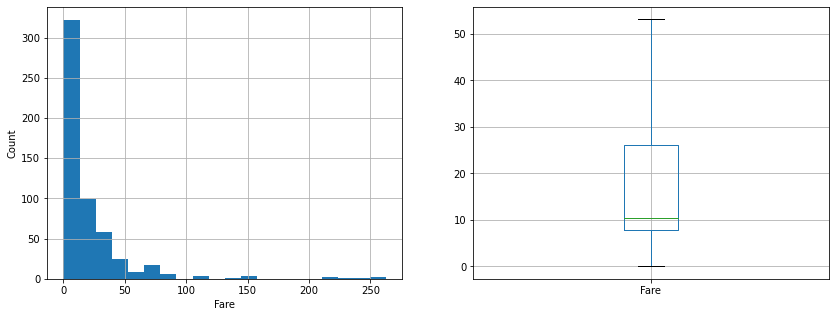

In [32]:
# 绘制遇难的票价分布图
plt.figure(figsize=(14, 5))
# 绘制票价分布图
plt.subplot(1, 2, 1)
train_data[train_data['Survived'] == 0]['Fare'].hist(bins = 20)
plt.xlabel('Fare')
plt.ylabel('Count')
# 绘制盒图
plt.subplot(1, 2, 2)
train_data[train_data['Survived'] == 0].boxplot(column='Fare', showfliers=False)
plt.show()

Cabin(船舱)

In [33]:
# 丢失值太多，不能用此数据分析出Cabin对生存率的影响，丢掉
train_data = train_data.drop('Cabin', axis=1)

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Embarked（登船港口）

In [35]:
# 各个港口上船人数及生还率
# 由于Embarked有两个缺失值，所以这里使用众数来填充
# 统计各个（港口）出现的次数
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [36]:
# S出现的次数最多，所以用S来填充两个缺失的数
train_data['Embarked'] = train_data['Embarked'].fillna('S')

In [37]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [38]:
# 填充后，各个港口登船的乘客数
n = train_data['Embarked'].value_counts()
n

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [39]:
# 海难后，各个港口登船的存活乘客数
s = train_data[train_data['Survived'] == 1]['Embarked'].value_counts()
d = train_data[train_data['Survived'] == 0]['Embarked'].value_counts()
s, d

(S    219
 C     93
 Q     30
 Name: Embarked, dtype: int64,
 S    427
 C     75
 Q     47
 Name: Embarked, dtype: int64)

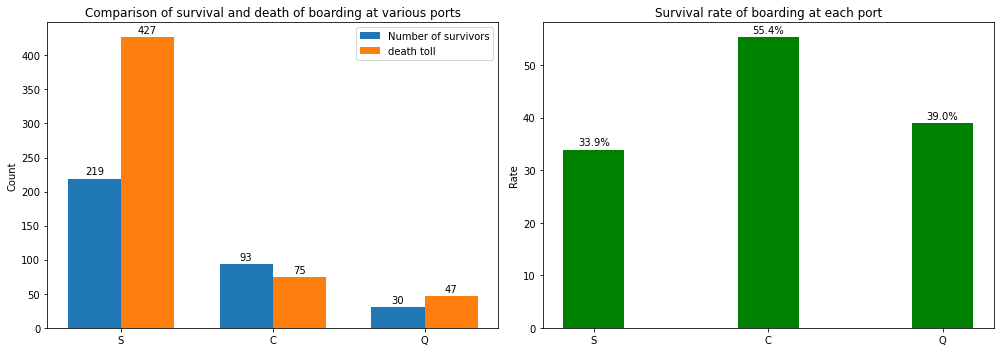

In [40]:
# 统计各个港口登船的存活率
s = [219, 93, 30]
n = [646, 168, 77]
d = [427, 75, 47]
# print(s, n, d)
labels = ['S', 'C', 'Q']
picture_bar(s, n, d, labels, title_1="Comparison of survival and death of boarding at various ports", 
            title_2="Survival rate of boarding at each port", width=0.35)
# S港口存活率：33.9%，C港口存活率：55.4%，Q港口存活率：39.0%

# 总结：

本次分析主要寻找了泰坦尼克号上的生还率与各因素（客舱等级、年龄、性别、上船港口等）的关系。
1、样本数量为891，海难发生后，生还者还剩342人，生还率为38.4%。

2、泰坦尼克号上有一、二、三等舱三种船舱类型。

 海难发生前，一等舱有 216 人，二等舱 184 人，三等舱 491 人，分别占总人数的 24%， 21%， 55%。
 海难发生后，一等舱、二等舱、三等舱的乘客人数变为136、87、119人，分别占总人数的 40%, 25%, 35%。
 一等舱生还率为 63%，二等舱为 47%，三等舱为 24%。可见客舱等级越高，生还率越高。
海难发生前，男性共577人，女性314人，男女比例为 65% 和 35%。

3、 海难发生后，男性变为109人，女性变为233人，男女比例变为 32% 和 68%。
 男性生还109人，生还率仅为19%。女性生还233人，生还率为74%，远远高于男性的19%。可见女性比男性在这次事故中更容易生还，表明“女士优先”的原则在本次事故中得到了发扬。
4、样本的891人中，平均年龄约为30岁， 标准差15岁，最小年龄为0.42，最大年龄80。按照儿童（0-12）、少年（12-18）、成人（18-65）、老年人（65及以上）划分为四类。

 四类人的生还率分别为58%，48%，39% 和9%。可见年龄越大，生还率越低。“尊老爱幼”的原则在本次事故中没有很好体现。
5、有兄弟姐妹的乘客有283人，生还132人，生还率为47%，

 而没有兄弟姐妹的乘客，有608人，生还210人，生还率为35%。可见有兄弟姐妹同船的生还率比没有兄弟姐妹同船的生还率要高。
6、有父母或子女同船的乘客有213人，生还109人，生还率为51%。

 没有父母子女同船的乘客有678人，生还233人，生还率仅为34%。
可见有父母或子女同船的生还率比没有的生还率要高。综合前一条分析，可以得出推论，有家人在船上的比没有家人在船上的生还概率要大。

7、票价与生还有一定相关性，生还者的平均票价要比未生还的高。

8、S港口生还人数最多，C次之，Q最少。从生还率来看，C港上船的生还率最高，Q次之，S生还率最低。